# Multiclass Simplex Tree Classification - 3 Classes

This notebook tests the SimplexTreeClassifier with 3-class data.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.join(current_dir, '..', '..', '..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from in2D.classifying.classes.simplex_tree_classifier import SimplexTreeClassifier
from in2D.classifying.classes.utilss.convexity_check import check_convexity, get_shared_vertices

# Class colors: red, blue, green, brown, purple
CLASS_COLORS = ['#e41a1c', '#377eb8', "#31a92d", "#a45121", "#9437a3"]
N_CLASSES = 3
CLASS_CMAP = ListedColormap(CLASS_COLORS[:N_CLASSES])

EPSILON = 0.30


In [2]:
def make_meshgrid(x, y, h=0.01):
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, xy, **params):
    Z = clf.predict(xy)
    Z = Z.reshape(xx.shape)
    return ax.contourf(xx, yy, Z, **params)

def find_simplices_to_remove(model, epsilon=EPSILON):
    """Find non-convex and same-side simplices to remove."""
    nonconvex_simplex_keys = set()
    crossing_simplices = model.identify_svm_crossing_simplices()
    
    n_hyperplanes = model.classifier.coef_.shape[0]
    for hp_idx in range(n_hyperplanes):
        weights = model.classifier.coef_[hp_idx]
        intercept = model.classifier.intercept_[hp_idx]
        
        for i, info1 in enumerate(crossing_simplices):
            simplex1 = info1['simplex']
            for info2 in crossing_simplices[i+1:]:
                simplex2 = info2['simplex']
                shared = get_shared_vertices(simplex1, simplex2)
                if len(shared) >= 2:
                    is_convex, _, _, _, _ = check_convexity(
                        simplex1, simplex2, weights, intercept,
                        global_tree=model.tree, epsilon=EPSILON
                    )
                    if not is_convex:
                        nonconvex_simplex_keys.add(frozenset(simplex1.vertex_indices))
                        nonconvex_simplex_keys.add(frozenset(simplex2.vertex_indices))
    
    same_side_simplex_keys = model.find_same_side_simplices()
    combined_keys = nonconvex_simplex_keys.union(same_side_simplex_keys)
    return nonconvex_simplex_keys, same_side_simplex_keys, combined_keys

def plot_before(model, X, y, nonconvex_keys, same_side_keys, xx, yy, x_min, x_max, y_min, y_max):
    """Plot the state before removal with highlighted simplices."""
    fig, ax = plt.subplots(figsize=(10, 8))
    xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
    plot_contours(ax, model.classifier, xx, yy, xy, cmap=CLASS_CMAP, alpha=0.3)
    
    for leaf in model.tree.get_leaves():
        vertices = leaf.get_vertices_as_tuples()
        if len(vertices) >= 3:
            closed = vertices + [vertices[0]]
            bx, by = zip(*closed)
            ax.plot(bx, by, 'k', linestyle='-', linewidth=1.5, alpha=0.7)
    
    for leaf in model.tree.get_leaves():
        simplex_key = frozenset(leaf.vertex_indices)
        is_nonconvex = simplex_key in nonconvex_keys
        is_same_side = simplex_key in same_side_keys
        if is_nonconvex and is_same_side:
            color, edge = 'purple', 'darkviolet'
        elif is_nonconvex:
            color, edge = 'lime', 'green'
        elif is_same_side:
            color, edge = 'yellow', 'orange'
        else:
            continue
        vertices = np.array(leaf.vertices)
        poly = patches.Polygon(vertices, closed=True, facecolor=color, alpha=0.5, edgecolor=edge, linewidth=2, zorder=6)
        ax.add_patch(poly)
    
    for idx, center in model.tree.get_splitting_points():
        ax.annotate(str(idx), center, fontsize=8, ha='center', va='center', 
                    bbox=dict(boxstyle='circle,pad=0.2', facecolor='white', edgecolor='black', alpha=0.8), zorder=10)
    
    for class_idx in np.unique(y):
        mask = y == class_idx
        ax.scatter(X[mask, 0], X[mask, 1], c=CLASS_COLORS[int(class_idx)], s=20, edgecolors='k', alpha=0.7, linewidths=0.5, label=f'Class {int(class_idx)}')
    ax.legend(loc='upper right')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"BEFORE: {len(nonconvex_keys)} non-convex, {len(same_side_keys)} same-side to remove")
    plt.show()

def plot_after(model, X, y, removed_count, xx, yy, x_min, x_max, y_min, y_max):
    """Plot the state after removal."""
    fig, ax = plt.subplots(figsize=(10, 8))
    xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
    plot_contours(ax, model.classifier, xx, yy, xy, cmap=CLASS_CMAP, alpha=0.3)
    
    for leaf in model.tree.get_leaves():
        vertices = leaf.get_vertices_as_tuples()
        if len(vertices) >= 3:
            closed = vertices + [vertices[0]]
            bx, by = zip(*closed)
            ax.plot(bx, by, 'k', linestyle='-', linewidth=1.5, alpha=0.7)
    
    for idx, center in model.tree.get_splitting_points():
        ax.annotate(str(idx), center, fontsize=8, ha='center', va='center', 
                    bbox=dict(boxstyle='circle,pad=0.2', facecolor='white', edgecolor='black', alpha=0.8), zorder=10)
    
    for class_idx in np.unique(y):
        mask = y == class_idx
        ax.scatter(X[mask, 0], X[mask, 1], c=CLASS_COLORS[int(class_idx)], s=20, edgecolors='k', alpha=0.7, linewidths=0.5, label=f'Class {int(class_idx)}')
    ax.legend(loc='upper right')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred) * 100
    ax.set_title(f"AFTER: {removed_count} simplices removed, Accuracy: {acc:.2f}%")
    plt.show()


## 1. Load Dataset

In [3]:
data = np.load('../datasets/multiclass_3classes_spiral.npz')
X, y = data['X'], data['y']

print(f"Dataset: {X.shape[0]} points, Classes: {np.unique(y)}")
print(f"Class distribution: {dict(zip(*np.unique(y, return_counts=True)))}")


Dataset: 999 points, Classes: [0 1 2]
Class distribution: {0: 333, 1: 333, 2: 333}


## 2. Build Model


In [4]:
C = 10000

root_vertices = [
    (0, 0),
    (2, 0),
    (0, 2)
]

subdivision_levels = 4
model = SimplexTreeClassifier(
    vertices=root_vertices,
    classifier=LinearSVC(C=C),
    subdivision_levels=subdivision_levels,
)
model.fit(X, y)

x_min, x_max = -0.05, 1.1
y_min, y_max = -0.05, 1.1
xx, yy = make_meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

print(f"Model built with {len(model.leaf_simplexes)} leaf simplices")

y_pred = model.predict(X)
acc = accuracy_score(y, y_pred) * 100
print(f"Initial accuracy: {acc:.2f}%")

model.tree.print_tree(show_only_splitting_points=False)

embedding = model.transform(X)
decision_values = model.classifier.decision_function(embedding)
print(decision_values.shape)




Model built with 81 leaf simplices
Initial accuracy: 60.86%
└── [0] vertices: [0, 1, 2]
    ├── [1] vertices: [1, 2, 3]
    │   ├── [2] vertices: [2, 3, 4]
    │   │   ├── [3] vertices: [3, 4, 5]
    │   │   │   ├── vertices: [4, 5, 6]
    │   │   │   ├── vertices: [3, 5, 6]
    │   │   │   └── vertices: [3, 4, 6]
    │   │   ├── [4] vertices: [2, 4, 5]
    │   │   │   ├── vertices: [4, 5, 7]
    │   │   │   ├── vertices: [2, 5, 7]
    │   │   │   └── vertices: [2, 4, 7]
    │   │   └── [5] vertices: [2, 3, 5]
    │   │       ├── vertices: [3, 5, 8]
    │   │       ├── vertices: [2, 5, 8]
    │   │       └── vertices: [2, 3, 8]
    │   ├── [6] vertices: [1, 3, 4]
    │   │   ├── [7] vertices: [3, 4, 9]
    │   │   │   ├── vertices: [4, 9, 10]
    │   │   │   ├── vertices: [3, 9, 10]
    │   │   │   └── vertices: [3, 4, 10]
    │   │   ├── [8] vertices: [1, 4, 9]
    │   │   │   ├── vertices: [4, 9, 11]
    │   │   │   ├── vertices: [1, 9, 11]
    │   │   │   └── vertices: [1, 4, 11]
  

## 3. Iterative Removal

### Iteration #1

Found: 53 non-convex, 6 same-side, 59 combined


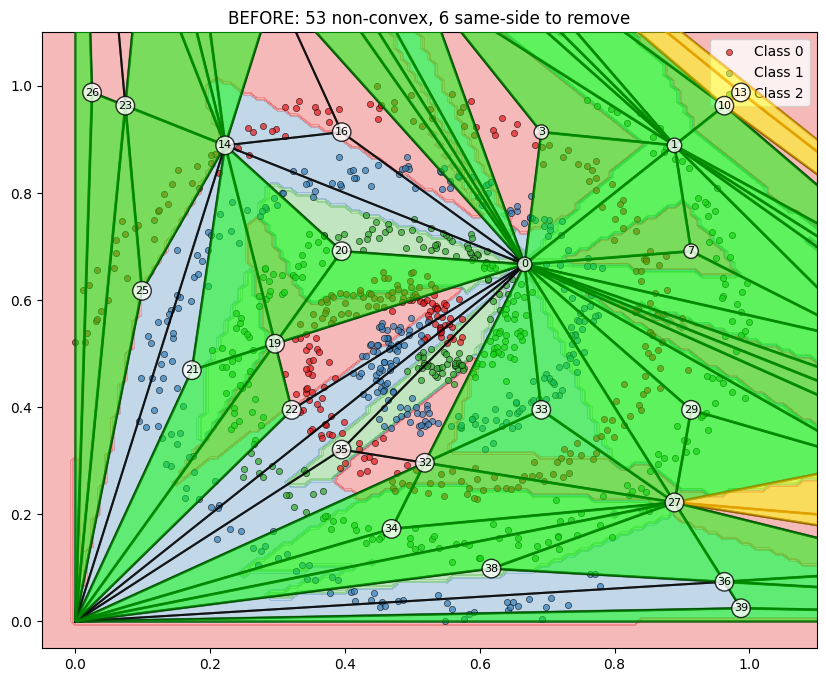

In [5]:
nonconvex_simplex_keys, same_side_simplex_keys, combined_keys = find_simplices_to_remove(model, EPSILON)
print(f"Found: {len(nonconvex_simplex_keys)} non-convex, {len(same_side_simplex_keys)} same-side, {len(combined_keys)} combined")
plot_before(model, X, y, nonconvex_simplex_keys, same_side_simplex_keys, xx, yy, x_min, x_max, y_min, y_max)

Removed 25. Leaves remaining: 31


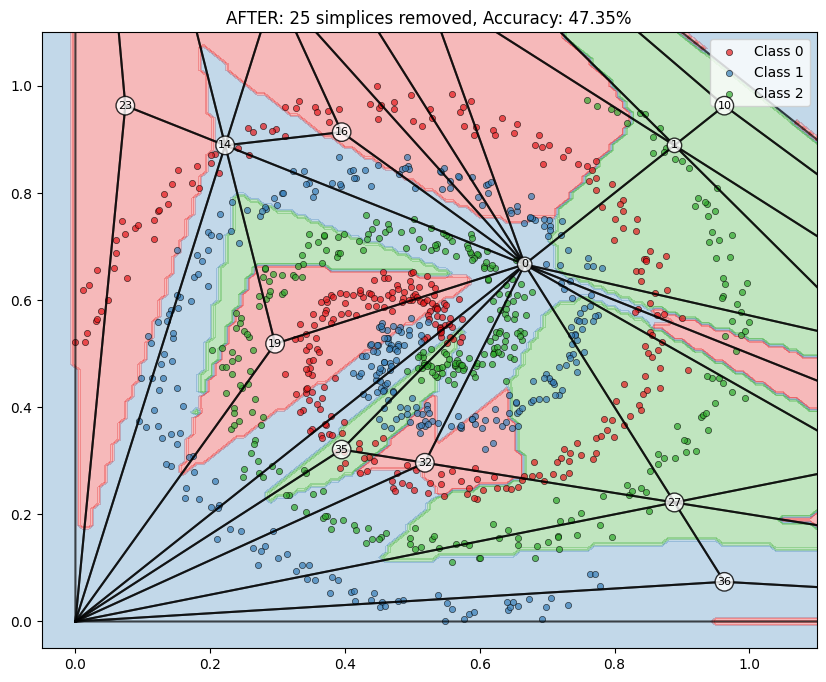

In [6]:
if len(combined_keys) > 0:
    removed_count = 0
    for simplex_key in combined_keys:
        if model.tree.remove_by_leaf_key(simplex_key):
            removed_count += 1
    model._build_node_lookup()
    model.fit(X, y)
    print(f"Removed {removed_count}. Leaves remaining: {len(model.tree.get_leaves())}")
    plot_after(model, X, y, removed_count, xx, yy, x_min, x_max, y_min, y_max)
else:
    print("Nothing to remove - converged!")

### Iteration #2

Found: 21 non-convex, 3 same-side, 24 combined


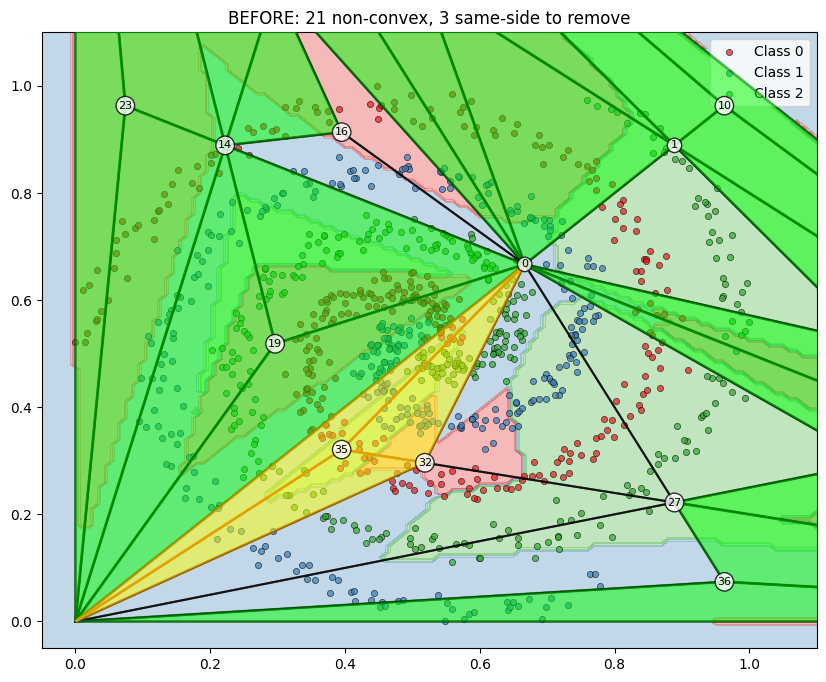

In [7]:
nonconvex_simplex_keys, same_side_simplex_keys, combined_keys = find_simplices_to_remove(model, EPSILON)
print(f"Found: {len(nonconvex_simplex_keys)} non-convex, {len(same_side_simplex_keys)} same-side, {len(combined_keys)} combined")
plot_before(model, X, y, nonconvex_simplex_keys, same_side_simplex_keys, xx, yy, x_min, x_max, y_min, y_max)

Removed 10. Leaves remaining: 11


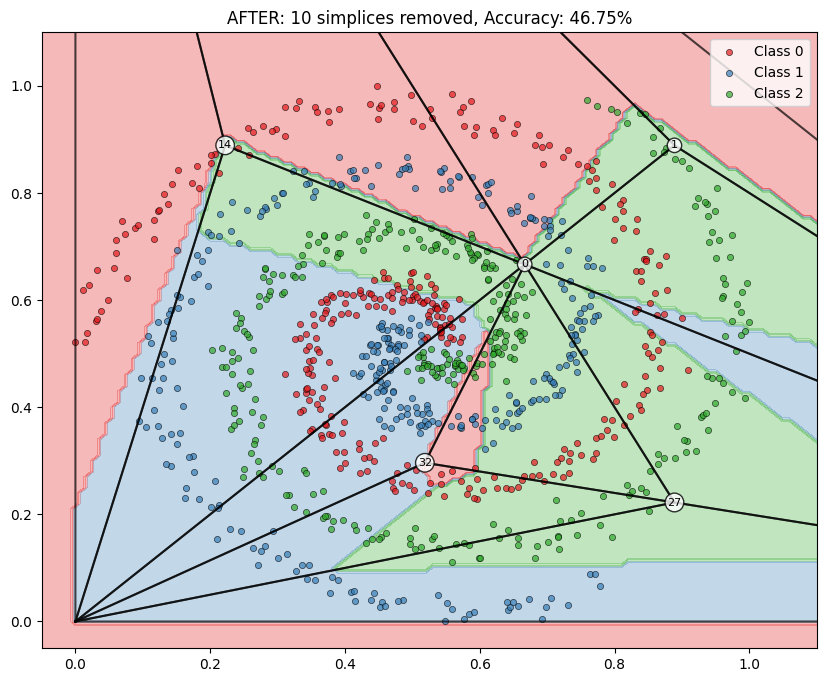

In [8]:
if len(combined_keys) > 0:
    removed_count = 0
    for simplex_key in combined_keys:
        if model.tree.remove_by_leaf_key(simplex_key):
            removed_count += 1
    model._build_node_lookup()
    model.fit(X, y)
    print(f"Removed {removed_count}. Leaves remaining: {len(model.tree.get_leaves())}")
    plot_after(model, X, y, removed_count, xx, yy, x_min, x_max, y_min, y_max)
else:
    print("Nothing to remove - converged!")

### Iteration #3

Found: 4 non-convex, 3 same-side, 7 combined


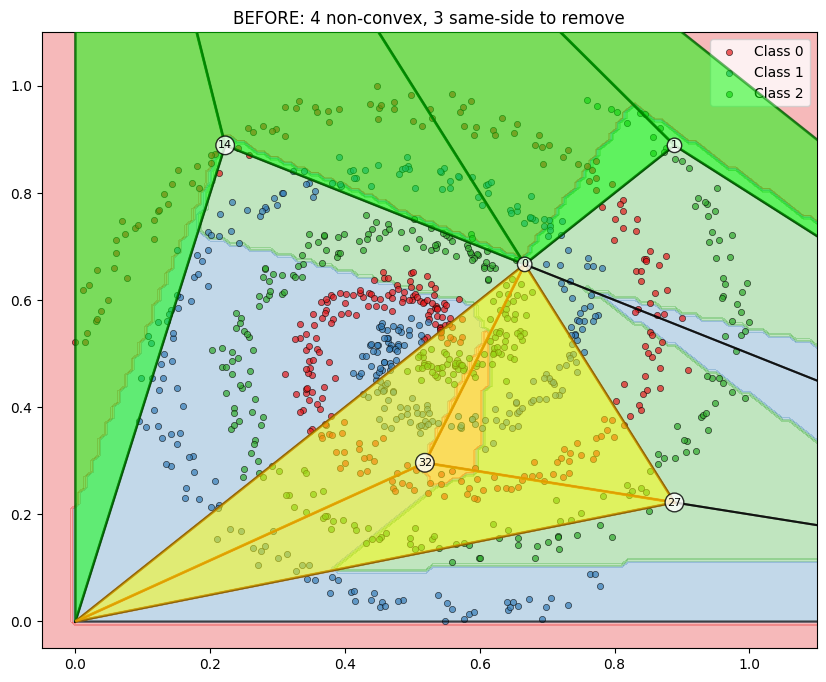

In [9]:
nonconvex_simplex_keys, same_side_simplex_keys, combined_keys = find_simplices_to_remove(model, EPSILON)
print(f"Found: {len(nonconvex_simplex_keys)} non-convex, {len(same_side_simplex_keys)} same-side, {len(combined_keys)} combined")
plot_before(model, X, y, nonconvex_simplex_keys, same_side_simplex_keys, xx, yy, x_min, x_max, y_min, y_max)

Removed 3. Leaves remaining: 5


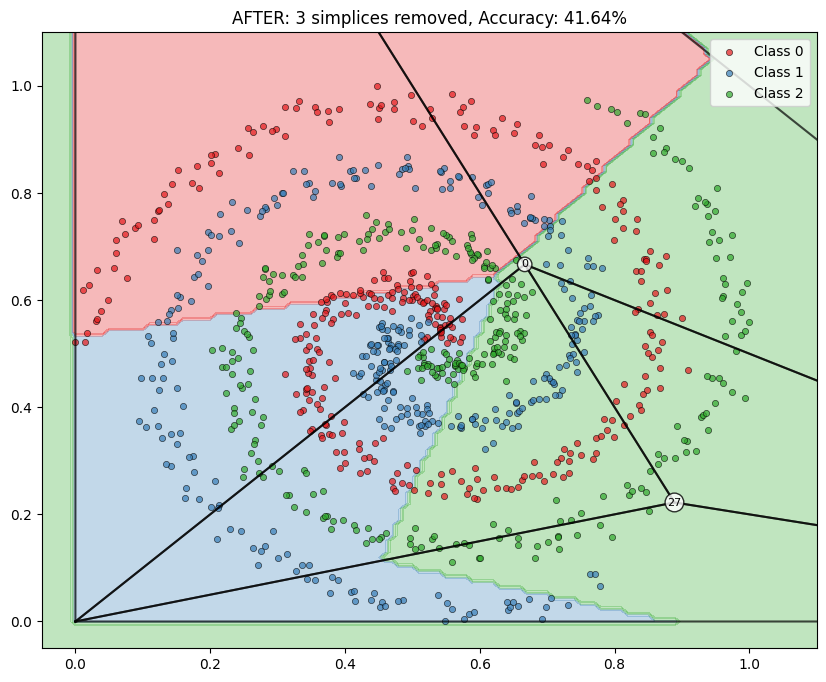

In [10]:
if len(combined_keys) > 0:
    removed_count = 0
    for simplex_key in combined_keys:
        if model.tree.remove_by_leaf_key(simplex_key):
            removed_count += 1
    model._build_node_lookup()
    model.fit(X, y)
    print(f"Removed {removed_count}. Leaves remaining: {len(model.tree.get_leaves())}")
    plot_after(model, X, y, removed_count, xx, yy, x_min, x_max, y_min, y_max)
else:
    print("Nothing to remove - converged!")

### Iteration #4

Found: 2 non-convex, 3 same-side, 5 combined


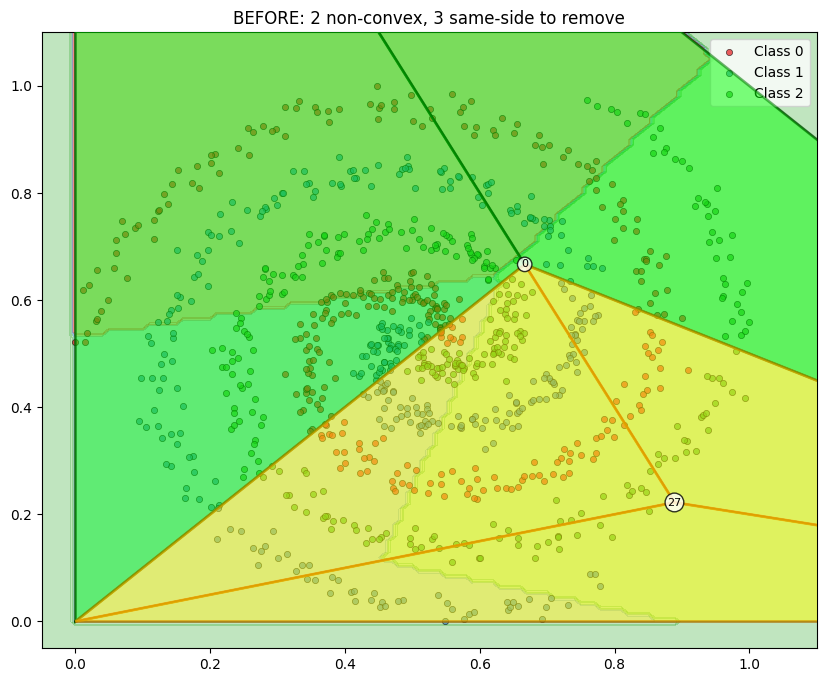

In [11]:
nonconvex_simplex_keys, same_side_simplex_keys, combined_keys = find_simplices_to_remove(model, EPSILON)
print(f"Found: {len(nonconvex_simplex_keys)} non-convex, {len(same_side_simplex_keys)} same-side, {len(combined_keys)} combined")
plot_before(model, X, y, nonconvex_simplex_keys, same_side_simplex_keys, xx, yy, x_min, x_max, y_min, y_max)

Removed 2. Leaves remaining: 1


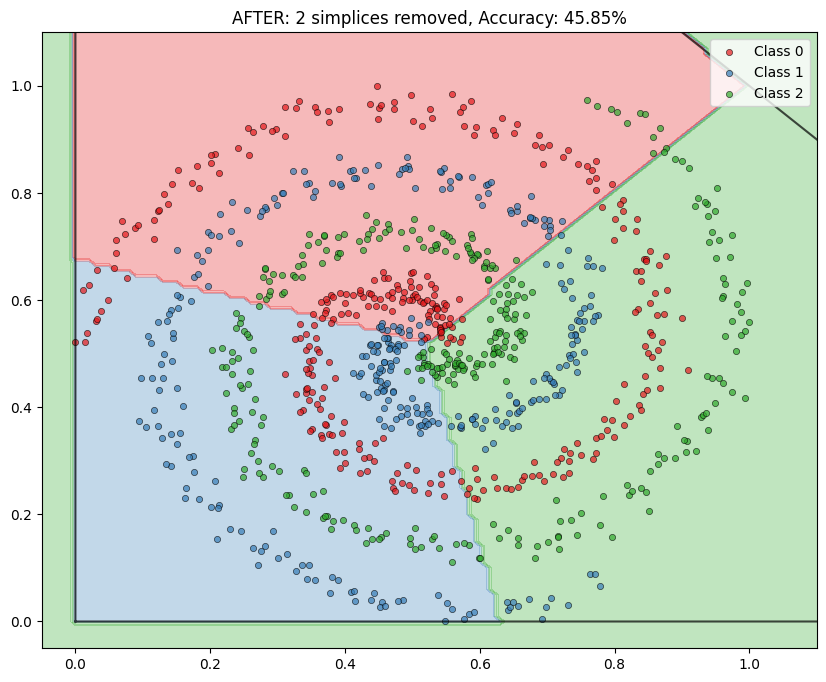

In [12]:
if len(combined_keys) > 0:
    removed_count = 0
    for simplex_key in combined_keys:
        if model.tree.remove_by_leaf_key(simplex_key):
            removed_count += 1
    model._build_node_lookup()
    model.fit(X, y)
    print(f"Removed {removed_count}. Leaves remaining: {len(model.tree.get_leaves())}")
    plot_after(model, X, y, removed_count, xx, yy, x_min, x_max, y_min, y_max)
else:
    print("Nothing to remove - converged!")

### Iteration #5

Found: 0 non-convex, 0 same-side, 0 combined


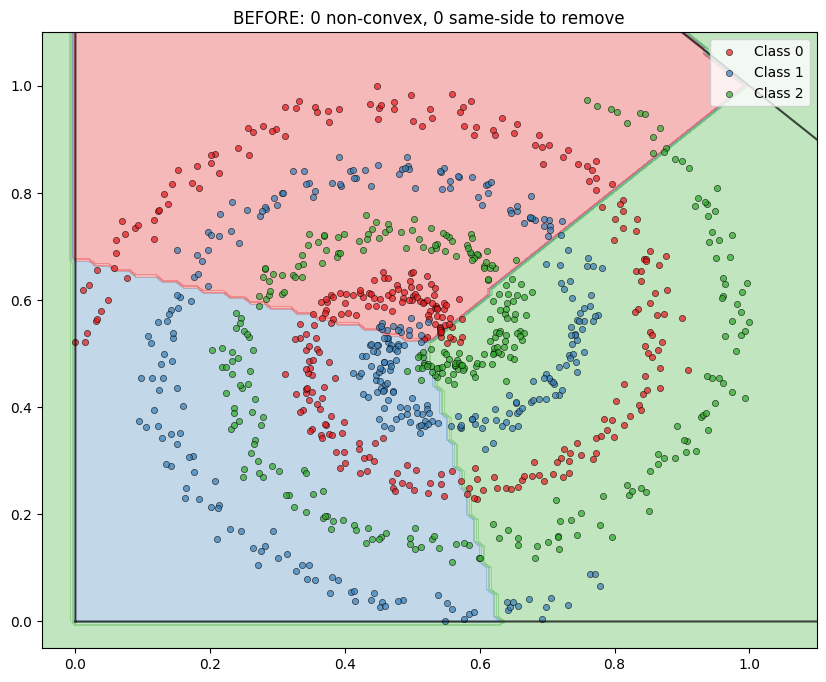

In [13]:
nonconvex_simplex_keys, same_side_simplex_keys, combined_keys = find_simplices_to_remove(model, EPSILON)
print(f"Found: {len(nonconvex_simplex_keys)} non-convex, {len(same_side_simplex_keys)} same-side, {len(combined_keys)} combined")
plot_before(model, X, y, nonconvex_simplex_keys, same_side_simplex_keys, xx, yy, x_min, x_max, y_min, y_max)

In [14]:
if len(combined_keys) > 0:
    removed_count = 0
    for simplex_key in combined_keys:
        if model.tree.remove_by_leaf_key(simplex_key):
            removed_count += 1
    model._build_node_lookup()
    model.fit(X, y)
    print(f"Removed {removed_count}. Leaves remaining: {len(model.tree.get_leaves())}")
    plot_after(model, X, y, removed_count, xx, yy, x_min, x_max, y_min, y_max)
else:
    print("Nothing to remove - converged!")

Nothing to remove - converged!


## 4. Final Tree

In [15]:
model.tree.print_tree(show_only_splitting_points=False)

y_pred = model.predict(X)
acc = accuracy_score(y, y_pred) * 100
print(f"\nFinal: {len(model.tree.get_leaves())} leaves, Accuracy: {acc:.2f}%")

└── vertices: [0, 1, 2]

Final: 1 leaves, Accuracy: 45.85%
